In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import astropy.units as u
from sunpy.time import TimeRange
import time
import sys
import os

import datetime as dt
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import gridspec,transforms

mpl.use('nbagg')
%matplotlib inline

In [1]:
sys.path.insert(1, '../../20201013_jupiter/')
from sk import LofarRaw
import ed_flagger as edf
import ilofar_ueds_rfi as ued

In [3]:
filename = '../udpoutput/uranus-stokesVectors_0_2020-12-15T20:04:00_19629670898060' #0 is I and 1 is V I assume
sV = '../udpoutput/uranus-stokesVectors_1_2020-12-15T20:04:00_19629670898060'
off_fname = '../udpoutput/offsource-stokesVectors_0_2020-12-15T20:04:00_19629670898060'
frange = [15,30]
sbs = np.arange(76,198)
obs_mode = 3
time_len_mins = 176.
trange = TimeRange(filename.split('_')[-2], time_len_mins*u.min)
xlabel = "Time on {} (UTC)".format(filename.split('_')[-2].split('T')[0])
ylabel = "Frequency (MHz)"
title = filename.split('/')[2]
no_sbs = 78
nsplit = 10

In [4]:
#on-beam
rawdata = LofarRaw(fname=filename, sbs=sbs, obs_mode=obs_mode, frange=frange)
rawdata.data = rawdata.data[:,:no_sbs] #need to do this because of the way subbands were set up for uranus observations! (only use 78 subbands!)
#off-beam
rawoffdata = LofarRaw(fname=off_fname, sbs=sbs, obs_mode=obs_mode, frange=frange)
rawoffdata.data = rawoffdata.data[:,:no_sbs]
#stokes V
sV_data = LofarRaw(fname=sV, sbs=sbs, obs_mode=obs_mode, frange=frange)
sV_data.data = sV_data.data[:,:no_sbs]



Time to read data: 0.001099s

Time to read data: 0.000149s

Time to read data: 0.000151s



In [5]:
df_chunk = ued.data_chunker(rawdata.data, nsplit)
off_chunk = ued.data_chunker(rawoffdata.data, nsplit)
sV_chunks = ued.data_chunker(sV_data.data, nsplit)
tchunks = trange.split(nsplit)

In [ ]:
strings = ["StokesI", "StokesI_OFF", "StokesV"]
#strings = ["StokesV"]
for i,df in enumerate([df_chunk, off_chunk, sV_chunks]):
    #for i,df in enumerate([sV_chunks]):
    total_f_sum = []
    print("Analysing {}".format(strings[i]))
    for n,df_split in enumerate(df):
        print("Analysing Chunk #{}".format(n+1))
        ylims, xlims = ued.get_data_lims(sbs, obs_mode, no_sbs, tchunks[n])
        print("Removing RFI")
        if strings[i]=='StokesV':
            df_norfi = ued.resample_dataset(df_split, f=610, stokesV=True)
        df_norfi = ued.resample_dataset(df_split, f=610) #resampled to 50 ms resolution
        rfi_mask = edf.basic_filter(df_norfi, 4.)
        rfi_begone = np.ma.MaskedArray(df_norfi, rfi_mask)
        df_rs = ued.resample_dataset(rfi_begone, f=6) #this is the 2nd resample so be wary of numbers here
        df_filtered = edf.basic_filter(df_rs.T, 4.) #4 sigma
        ued.plot_data(df_filtered, None, None, xlims, ylims, xlabel, ylabel, "ed_flags/{}".format(strings[i])+str(n+1), "Electrostatic Filtering {}".format(strings[i]), gs=True)
        f_sum = edf.get_hist_dynspec(df_filtered, axis=0)
        total_f_sum.append(f_sum)
        #t_sum = edf.get_hist_dynspec(df_filtered, axis=0)
    plt.close()
    f = plt.figure()
    f.set_facecolor('white')
    plt.bar(np.arange(f_sum.shape[0]), np.sum(total_f_sum, axis=0))
    plt.savefig("ed_flags/histogram_frequency_{}".format(strings[i]))
    os.rename('trigger_indices.dat', 'trigger_indices_{}.dat'.format(strings[i]))

In [6]:
import waterfall as wf

In [45]:
dft, newt, ylims, xlims = wf.zoom_window(rawdata, df_chunk[4], tchunks[4], 5, 4, no_sbs)

In [50]:
ued.plot_data(dft, np.nansum(dft.T, axis=0), np.nansum(dft.T, axis=1), xlims, ylims, xlabel, ylabel, "ed_flags/event_212900UTC/zoom4", "ED event zoom", gs=True)


Plotting...



In [46]:
dft, newt, ylims, xlims = wf.zoom_window(rawdata, dft, newt, 4, 1, no_sbs)


In [47]:
dft, newt, ylims, xlims = wf.zoom_window(rawdata, dft, newt, 5, 0, no_sbs)

In [49]:
dft, newt, ylims, xlims = wf.zoom_window(rawdata, dft, newt, 10, 9, no_sbs)

In [28]:
newt

    Start: 2020-12-15 21:29:21
    End:   2020-12-15 21:30:14
    Center:2020-12-15 21:29:48
    Duration:0.0006111111111111178 days or
           0.014666666666666828 hours or
           0.8800000000000097 minutes or
           52.80000000000058 seconds

In [48]:
c = np.arange(1, ued.shape[1] + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

In [49]:
%matplotlib inline

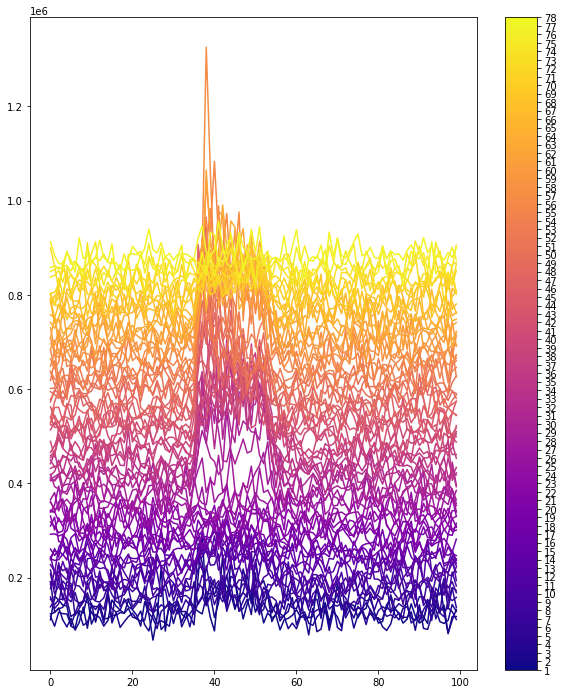

In [51]:
f, ax = plt.subplots(figsize=(10,12))
f.set_facecolor('white')
for i in range(ued.shape[1]-1):
    plt.plot(ued[:,-i]+i*1e4, c=cmap.to_rgba(i + 1))
plt.colorbar(cmap, ticks=c)

In [57]:
import seaborn as sns
import pandas as pd

In [58]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
ued = pd.DataFrame(ued)
g = sns.FacetGrid(ued, row="g", hue="g", aspect=15, height=.5, palette=pal)

KeyError: 'g'

In [113]:
u2 = np.ndarray.flatten(ued)

In [91]:
f = np.tile(list(np.arange(ued.shape[1])), ued.shape[0])

In [118]:
f.shape

(7800,)

In [140]:
df = pd.DataFrame(dict(x=u2, y=f))
#m = df.f.map(ord)
#df["x"] += m

In [146]:
df.x

0       110378.0
1       120089.0
2       152897.0
3       107890.0
4       110187.0
          ...   
7795     86812.0
7796    132189.0
7797     81021.0
7798     97236.0
7799    117976.0
Name: x, Length: 7800, dtype: float32

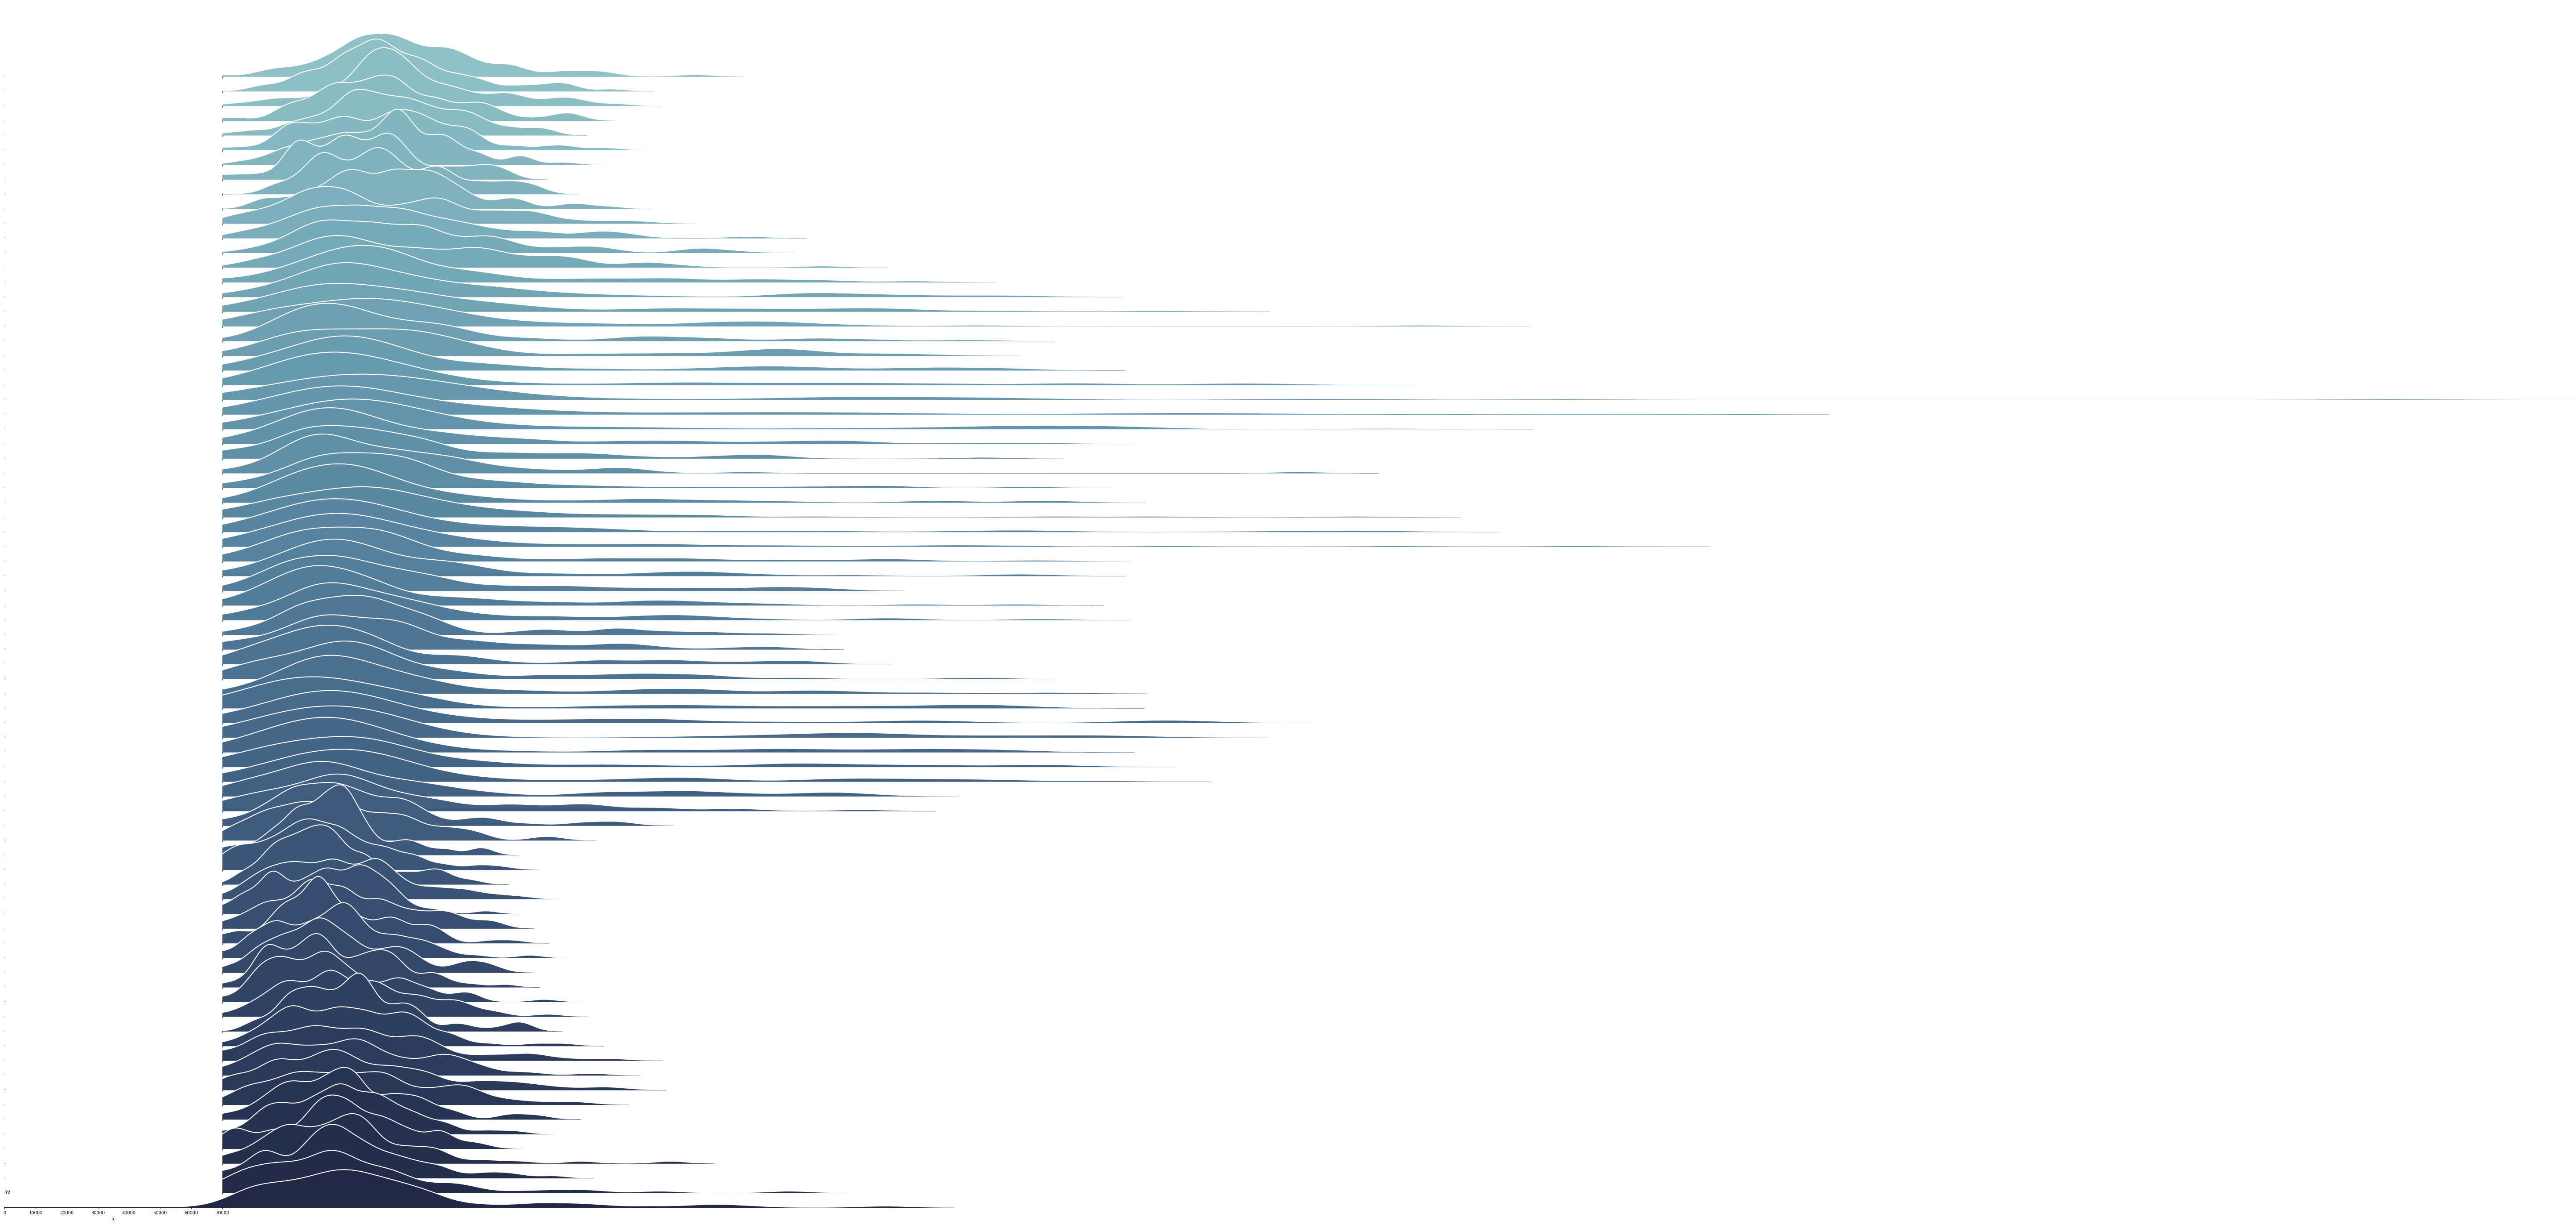

In [170]:
pal = sns.cubehelix_palette(80, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="y", hue="y", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(label, "x")
g.fig.subplots_adjust(hspace=-0.8)
g.set_titles("")
#g.map(plt.xlim([0,100000]))
for i in g.axes:
    for ax in i:
        ax.set_xlim([0,70000])
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [96]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

<AxesSubplot:>

In [ ]:
def waterfall_plot(data):
    """
    This works for a 2d dynamic spectrum where data is [time, frequency]
    """

    flatten = np.ndarray.flatten(data)
    f = np.tile(list(np.arange(data.shape[1])), data.shape[0])
    df = pd.DataFrame(dict(x=u2, y=f))

    pal = sns.cubehelix_palette(80, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="y", hue="y", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "x",
        bw_adjust=.5, clip_on=False,
        fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    g.map(label, "x")
    g.fig.subplots_adjust(hspace=-0.8)
    g.set_titles("")
    axes = g.axes
    for ax in axes:
        ax.set_xlim([0,70000])
    g.set(yticks=[])
    g.despine(bottom=True, left=True)


In [129]:
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

<bound method Series.map of 0      A
1      B
2      C
3      D
4      E
      ..
495    F
496    G
497    H
498    I
499    J
Name: g, Length: 500, dtype: object>

In [ ]:
for i in range(ued.shape[1]):
    f, ax = plt.subplots(figsize=(10,12))
    f.set_facecolor('white')
    plt.plot(ued[:,i])
    plt.ylabel('Arbitrary voltage')
    plt.xlabel('Time in 81us steps from 20:31:40.5693 to ...:40.5775 UTC')
    plt.savefig('ed_flags_gif/image_00{}'.format(i))
    plt.close()

In [ ]:
t3